### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import string
import os
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


### Define Global Functions

In [2]:
def print_results(cv_h, show_all = False):
    """Print out results of the hyperparameter optimization"""
    print('Best:')
    print(round(cv_h.best_score_, 3), ' for ', cv_h.best_params_)
    if show_all:
        print('All:')
        for mean, params in zip(cv_h.cv_results_['mean_test_score'], 
                                cv_h.cv_results_['params']):
                print('{}  for {}'.format(round(mean, 3), params))

In [3]:
def make_song_df(path,artists):
    """ Build a data frame from all the text files which consist in path regaring to the artists"""
    corpus = []
    artists_name = []
    songs_name = []
    folders = [name for name in os.listdir(path) if (( name[0] != '.' ) & (name in artists))]
    for folder in folders:
        files = os.listdir(f'{path}/{folder}')
        print(f'{len(files)} unique lyrics from {folder} have been added to datafram.')
        for file in files:
            if os.path.isfile(f'{path}/{folder}/{file}'):
                song_name = os.path.splitext(file)[0]
                song_name = song_name.replace('_', ' ')
                songs_name.append(song_name)
                artists_name.append(folder)
                lyric = open(file=f'{path}/{folder}/{file}',mode='r').read()
                corpus.append(lyric)
            else:
                continue
    dict = {'artist_name': artists_name, 'song_name': songs_name, 'lyric': corpus} 
    df = pd.DataFrame(dict)
    return df

In [4]:
def print_evaluation_metrics(model,X_train,y_train,X_test,y_test):
    
    """ Print out some evaluation metrics """
    
    print(f'train score: {round(model.score(X_train,y_train),2)}')
    print(f'test score: {round(model.score(X_test,y_test),2)}')

In [5]:
# save evaluation metrics using cross validation
def save_evaluation_metrics(classifier,classifier_name, summary, X, y):
    
    AUC = round(cross_val_score(classifier, X, y, cv = 5, scoring='roc_auc_ovr_weighted').mean(),2)
    accuracy = round(cross_val_score(classifier, X, y, cv = 5, scoring='accuracy').mean(),2)
    precision = round(cross_val_score(classifier, X, y, cv = 5, scoring='precision_weighted').mean(),2)
    recall = round(cross_val_score(classifier, X, y, cv = 5, scoring='recall_weighted').mean(),2)
    f1 = round(cross_val_score(classifier, X, y, cv = 5, scoring='f1_weighted').mean(),2)
    
    summary['Classifier Name'].append(classifier_name)
    summary['AUC'].append(AUC)
    summary['Accuracy'].append(accuracy)
    summary['Precision'].append(precision)
    summary['Recall'].append(recall)
    summary['F1'].append(f1)
    
    
    return summary

### Load Data

In [6]:
# build a dataframe from lyrics files
df = make_song_df('../data/',['coldplay','rihanna','jenniferlopez'])
df

181 unique lyrics from coldplay have been added to datafram.
186 unique lyrics from jenniferlopez have been added to datafram.
158 unique lyrics from rihanna have been added to datafram.


,artist_name,song_name,lyric
0,coldplay,voodoo,\n\n[Chris Martin & Tiwa Savage:]\nAm I sick i...
1,coldplay,the hardest part,"\n\nAnd the hardest part\nWas letting go, not ..."
2,coldplay,parachutes,"\n\nIn a haze, a stormy haze\nI'll be round\nI..."
3,coldplay,the escapist,\n\nAnd in the end\nWe lie awake\nAnd we dream...
4,coldplay,fix you,"\n\nWhen you try your best, but you don't succ..."
...,...,...,...
520,rihanna,sm,"\n\nNa-na-na, come on\nNa-na-na, come on\nNa-n..."
521,rihanna,now i know,\n\nTook a chance\nRolled the dice on me and y...
522,rihanna,half of me,\n\nYou saw me on a television\nSetting fire t...
523,rihanna,photographs,\n\nHere's a little story I've gotta tell\n'Bo...


### Exploratory Data Analysis

### Logistic Regression

In [7]:
# define features and target
X = df['lyric']
y = df['artist_name']

In [8]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((420,), (105,))

#### Define Preprocessing Pipeline

In [9]:
# define tekonizer function
def my_tokenizer(text):
    table = str.maketrans('','',string.punctuation)
    # split the text into separate words
    text = text.split()
    #remove punctuations
    text = [word.translate(table) for word in text]
    #remove words which are less than two character e.g. 's and a
    text = [word for word in text if(len(word)>2)]
    #remove words which include of numbers
    text = [word for word in text if(word.isalpha())]
    return text

In [10]:
# define pipeline for preprocessing (equivalent with using TfidfVectorizer)
preprocessor = Pipeline([
    ('cv', CountVectorizer(lowercase=True,max_df=0.7,min_df=0.05,tokenizer=my_tokenizer)),
    ('tf', TfidfTransformer())   
])

In [11]:
# take a look at X after preprocessing
matrix = preprocessor.fit_transform(X_train)
tfdf = pd.DataFrame(matrix.todense(), columns=preprocessor['cv'].get_feature_names())
tfdf.describe()

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,about,after,again,aint,air,all,alone,alright,always,amor,...,work,world,would,wrong,yeah,yes,youll,your,youre,youve
count,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,...,420.00000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000,420.000000
mean,0.016830,0.004906,0.014363,0.021844,0.005754,0.047647,0.007280,0.011210,0.012794,0.025572,...,0.00767,0.024648,0.017456,0.010242,0.044970,0.011825,0.016486,0.053897,0.032410,0.009500
std,0.050990,0.026182,0.061480,0.075388,0.028584,0.079773,0.031787,0.053396,0.056295,0.126874,...,0.04686,0.076469,0.061136,0.038444,0.100604,0.058685,0.074029,0.080324,0.061635,0.048998
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.013705,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.027032,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.061111,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.047425,0.000000,0.000000,0.073829,0.041099,0.000000
max,0.318957,0.264374,0.667032,0.745326,0.251574,0.750236,0.304906,0.565914,0.670481,0.943140,...,0.72298,0.614276,0.600805,0.364801,0.812448,0.621479,0.792390,0.532555,0.360782,0.651154


In [12]:
# print out the stop words
preprocessor['cv'].stop_words_

{'sucker',
 'luh',
 'wilding',
 'sprinkling',
 'tables',
 'reel',
 'different',
 'monkeys',
 'countdown',
 'victim',
 'africa',
 'inception',
 'runway',
 'pegar',
 'conquistar',
 'gini',
 'bronx',
 'fast',
 'danger',
 'shaken',
 'bilingual',
 'bobo',
 'mustve',
 'protagonico',
 'amar',
 'trumpets',
 'weight',
 'fading',
 'elvis',
 'flavor',
 'cent',
 'tuya',
 'rags',
 'blockbyblock',
 'comprometemos',
 'hollowest',
 'mention',
 'lagrima',
 'dividing',
 'thousandth',
 'rifles',
 'esteem',
 'wuh',
 'savior',
 'target',
 'loca',
 'franco',
 'primero',
 'state',
 'rush',
 'lover',
 'mucho',
 'mountainside',
 'pushed',
 'led',
 'kind',
 'lemme',
 'ruisseaux',
 'race',
 'finally',
 'strangers',
 'cintura',
 'destiny',
 'pure',
 'between',
 'aggressive',
 'rebmemer',
 'verdad',
 'challenge',
 'useumyeo',
 'available',
 'decreto',
 'aringing',
 'diamond',
 'kangaroos',
 'amulet',
 'shoulda',
 'dita',
 'minimal',
 'puedas',
 'drug',
 'chocha',
 'glass',
 'strength',
 'fallen',
 'snooze',
 'rida

#### Create Classifier

In [13]:
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('m_lr', LogisticRegression(max_iter=1000,C=0.18))    
])

In [14]:
lr.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cv',
                                  CountVectorizer(max_df=0.7, min_df=0.05,
                                                  tokenizer=<function my_tokenizer at 0x7fdd3a050f70>)),
                                 ('tf', TfidfTransformer())])),
                ('m_lr', LogisticRegression(C=0.18, max_iter=1000))])

In [15]:
print_evaluation_metrics(lr,X_train,y_train,X_test,y_test)

train score: 0.78
test score: 0.7


#### Tune Hyperparameters

In [16]:
# get list of hyperparameters
lr.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'm_lr', 'preprocessor__memory', 'preprocessor__steps', 'preprocessor__verbose', 'preprocessor__cv', 'preprocessor__tf', 'preprocessor__cv__analyzer', 'preprocessor__cv__binary', 'preprocessor__cv__decode_error', 'preprocessor__cv__dtype', 'preprocessor__cv__encoding', 'preprocessor__cv__input', 'preprocessor__cv__lowercase', 'preprocessor__cv__max_df', 'preprocessor__cv__max_features', 'preprocessor__cv__min_df', 'preprocessor__cv__ngram_range', 'preprocessor__cv__preprocessor', 'preprocessor__cv__stop_words', 'preprocessor__cv__strip_accents', 'preprocessor__cv__token_pattern', 'preprocessor__cv__tokenizer', 'preprocessor__cv__vocabulary', 'preprocessor__tf__norm', 'preprocessor__tf__smooth_idf', 'preprocessor__tf__sublinear_tf', 'preprocessor__tf__use_idf', 'm_lr__C', 'm_lr__class_weight', 'm_lr__dual', 'm_lr__fit_intercept', 'm_lr__intercept_scaling', 'm_lr__l1_ratio', 'm_lr__max_iter', 'm_lr__multi_class', 'm_lr__n_jobs', 'm_

In [25]:
parameters = {'m_lr__C': np.arange(0.01,1,0.01)}

In [26]:
cv_h =  GridSearchCV(estimator=lr,param_grid=parameters,cv=5,n_jobs=-1)

In [27]:
cv_h.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        Pipeline(steps=[('cv',
                                                         CountVectorizer(max_df=0.7,
                                                                         min_df=0.05,
                                                                         tokenizer=<function my_tokenizer at 0x7fdd3a050f70>)),
                                                        ('tf',
                                                         TfidfTransformer())])),
                                       ('m_lr',
                                        LogisticRegression(C=0.18,
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'m_lr__C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12...
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99])})

In [20]:
# Print results of hyperparameter optimization using random search       
print_results(cv_h, show_all=False)

Best:
0.679  for  {'m_lr__C': 0.65}


In [21]:
# Extract best model
lr_best = cv_h.best_estimator_
lr_best

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cv',
                                  CountVectorizer(max_df=0.7, min_df=0.05,
                                                  tokenizer=<function my_tokenizer at 0x7fdd3a050f70>)),
                                 ('tf', TfidfTransformer())])),
                ('m_lr', LogisticRegression(C=0.65, max_iter=1000))])

#### Evaluate Classifier

/Users/milad/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


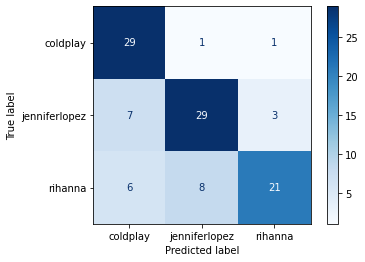

In [22]:
# plot confusion matrix
metrics.plot_confusion_matrix(lr_best, X_test, y_test,
                              values_format=".4g", 
                              cmap='Blues'
                             );

In [23]:
print_evaluation_metrics(lr_best,X_train,y_train,X_test,y_test)

train score: 0.85
test score: 0.75


In [24]:
summary = {'Classifier Name':[],'AUC':[],'Accuracy':[]
           ,'Precision':[],'Recall':[],'F1':[]}

summary = save_evaluation_metrics(lr_best,'Logistic Regression',summary,X,y)
summary

{'Classifier Name': ['Logistic Regression'],
 'AUC': [0.85],
 'Accuracy': [0.69],
 'Precision': [0.68],
 'Recall': [0.69],
 'F1': [0.68]}